This notebook shows how to use the general interface in HiGP for regression problems with a SciPy optimizer.

We will apply GP to a one-dimensional dataset $X$ randomly sampled from $[0, 1]$. The corresponding label is generated using a Gaussian Random Field. The data is stored in the file "Example00-EasyGPR.npz".

In this example, we use the Matern 3/2 kernel function in the form
$$
\mathcal{K}(x,y)=f^2 (1 + \sqrt{3} \frac{\|x - y\|_2}{l}) \exp\left(\frac{-\sqrt{3}\|x - y\|_2}{l}\right).
$$

As we hope to make the actual parameters in $(0,\infty)$, we train our parameters in $\mathbb{R}$, and apply the softplus transformation to get the actual parameters.

In [1]:
import higp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint
%matplotlib inline

Load the dataset.

In [2]:
np_dtype = np.float32

# Load the dataset
data = np.load("Example00-EasyGPR.npz")
train_x = data["train_x"].astype(np_dtype)
train_y = data["train_y"].astype(np_dtype)
test_x = data["test_x"].astype(np_dtype)
test_y = data["test_y"].astype(np_dtype)

n_train = train_x.shape[1]
n_test = test_x.shape[1]

Create a GP Regression problem struct. 

We use Matern 3/2 kernel by setting `kernel_type = 2`.

In [3]:
gprproblem = higp.gprproblem.setup(data = train_x, label = train_y, kernel_type = 2)

Run the LBFGS optimizer. We give a bound for the optimizer since it might run too far away.

In [4]:
result = higp.gpr_scipy_minimize(gprproblem, dtype = np_dtype, bounds = ((-20.0, 20.0), (-5.0, 5.0), (-5.0, 5.0)))

Setting up GPR problem with 400 samples and 1 features
Init gpr problem done
Creating GPR problem
Data type: float
Kernel type: Matern 3/2
Transform type: softplus
Using preconditioned GP, kernel matrix form: dense / fall back to on-the-fly
AFN preconditioner parameters: rank 50, lfil 0
LanQ parameters: niter 10, nvec 10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86794D+02    |proj g|=  2.00000D+01

At iterate    1    f=  2.47952D+02    |proj g|=  2.33770D+01

At iterate    2    f= -2.22854D+01    |proj g|=  2.42088D+01

At iterate    3    f= -2.07539D+02    |proj g|=  2.30294D+01

At iterate    4    f= -2.10032D+02    |proj g|=  2.29955D+01

At iterate    5    f= -2.43201D+02    |proj g|=  2.26620D+01

At iterate    6    f= -2.60881D+02    |proj g|=  5.37622D+00

At iterate    7    f= -2.63599D+02    |proj g|=  1.34608D+01

At iterate   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     33     17     0     0   1.199D-01  -2.715D+02
  F =  -271.53305053710938     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


Run predictions with the initial parameters and the final parameters.

In [5]:
Pred0 = higp.gpr_prediction(data_train = train_x,
                            label_train = train_y,
                            data_prediction = test_x,
                            kernel_type = 2,
                            pyparams = np.hstack((0.0, 0.0, 0.0)).astype(np_dtype))

Pred = higp.gpr_prediction(data_train = train_x,
                           label_train = train_y,
                           data_prediction = test_x,
                           kernel_type = 2,
                           pyparams = result.x.astype(np_dtype))

Now let us check the root mean squared errir (RMSE) of the predition.

In [6]:
rmse0 = np.linalg.norm(Pred0[0] - test_y) / np.sqrt(float(n_test))
rmse = np.linalg.norm(Pred[0] - test_y) / np.sqrt(float(n_test))
print("RMSE (before training): %g, RMSE (after training): %g\n" % (rmse0, rmse))

RMSE (before training): 0.460757, RMSE (after training): 0.091351



Finally, plot the results.

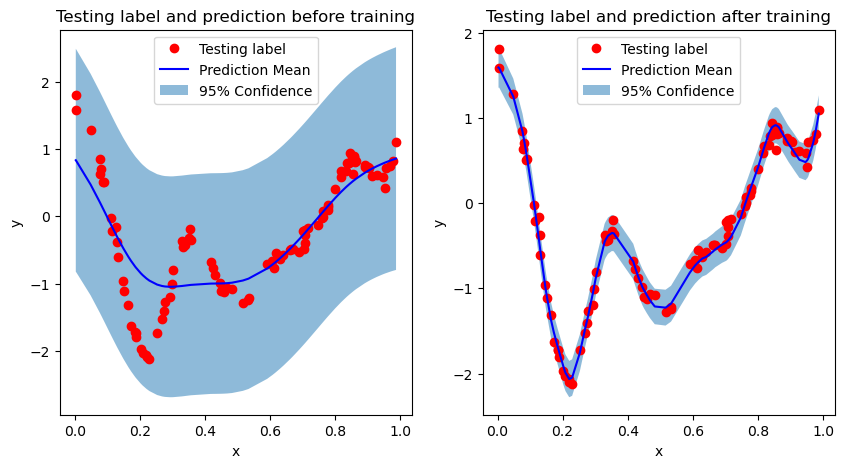

In [7]:
idx = np.argsort(test_x[0,:])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(test_x[0,idx], test_y[idx], 'ro')
axs[0].plot(test_x[0,idx], Pred0[0][idx], 'b-')
axs[0].fill_between(test_x[0,idx], Pred0[0][idx] - 1.96 * Pred0[1][idx], Pred0[0][idx] + 1.96 * Pred0[1][idx], alpha=0.5)
axs[0].set_title('Testing label and prediction before training')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend(['Testing label', 'Prediction Mean', '95% Confidence'], loc='upper center')
axs[1].plot(test_x[0,idx], test_y[idx], 'ro')
axs[1].plot(test_x[0,idx], Pred[0][idx], 'b-')
axs[1].fill_between(test_x[0,idx], Pred[0][idx] - 1.96 * Pred[1][idx], Pred[0][idx] + 1.96 * Pred[1][idx], alpha=0.5)
axs[1].set_title('Testing label and prediction after training')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].legend(['Testing label', 'Prediction Mean', '95% Confidence'], loc='upper center')
plt.show()
plt.close(fig)